In [22]:
#!/usr/bin/env python

'''
GA Data Science Q2 2016

Code walk-through 15: Time series

* Aggregation
* Rolling and exponentially weighted averages
* Autocorrelation and stationarity
* AR(I)MA modelling
'''

import numpy as np
import pandas as pd

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

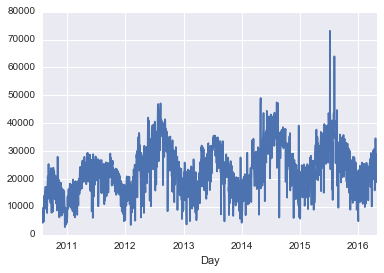

In [24]:
CYCLE_HIRES_URL = 'https://files.datapress.com/london/dataset/number-bicycle-hires/2016-05-17T09:24:57/tfl-daily-cycle-hires.xls'

# Load TfL Cycle Hire dataset
hires = pd.read_excel(CYCLE_HIRES_URL, sheetname='Data')

# Convert 'Day' to 'datetime' and set as index
hires.Day = pd.to_datetime(hires.Day, unit='D')
hires.set_index('Day', inplace=True) #if you set index to day it allows you to manipulate data by day

# Extract first column (daily hires) and convert to 'float'
hires = hires.iloc[:,0].astype('float').to_frame('Hires')

# Plot time series
hires.Hires.plot()

In [21]:
hires

,Hires
Day,
2010-07-30,6897.0
2010-07-31,5564.0
2010-08-01,4303.0
2010-08-02,6642.0
2010-08-03,7966.0
2010-08-04,7893.0
2010-08-05,8724.0
2010-08-06,9797.0
2010-08-07,6631.0


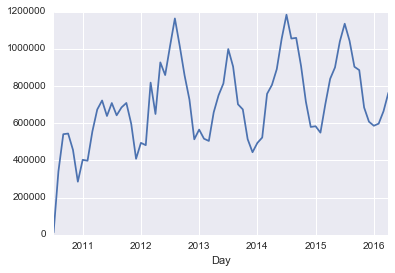

In [3]:
'''
Aggregation
'''
#although days does give us idea of trend and seasonality but too complex, pandas resamlple just changes frquency of time 
#series from daily to monthly
#to frame converts into a series to datafrmae

# Resample at monthly resolution
monthly_hires = hires.Hires.resample('M').sum().to_frame()
monthly_hires.Hires.plot()

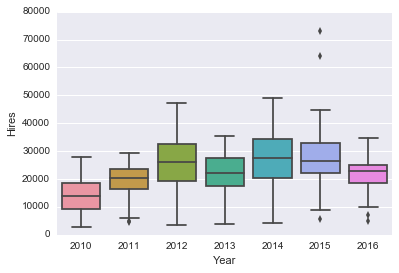

In [4]:
# Extract year, month, and weekday from index
hires['Year'] = hires.index.year
hires['Month'] = hires.index.month
hires['Weekday'] = hires.index.weekday

# Box plot of daily hires by year, month, and weekday
sns.boxplot(x='Year', y='Hires', data=hires)
#2016 is missing data and need to rememebr most hires are during summer which 2016 doesn't have

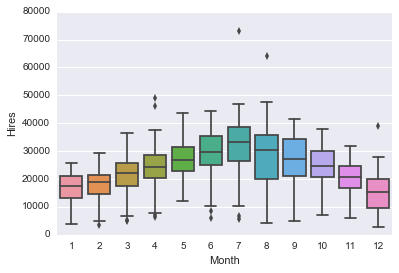

In [5]:
sns.boxplot(x='Month', y='Hires', data=hires)

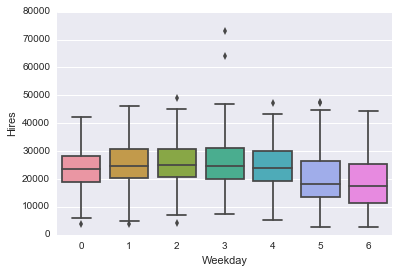

In [6]:
#see monday is lower, is this due to bank holiday mondays, people cycle less on the weekends, this maybe due to the fact commuters
#mainly use bikes
sns.boxplot(x='Weekday', y='Hires', data=hires)

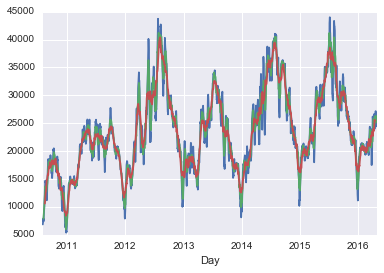

In [7]:
'''
Rolling and exponentially weighted averages
'''

# Rolling average;the bigger the window, the smoother the time series

hires.Hires.rolling(window=7, center=True).mean().plot()
hires.Hires.rolling(window=14, center=True).mean().plot()
hires.Hires.rolling(window=30, center=True).mean().plot()

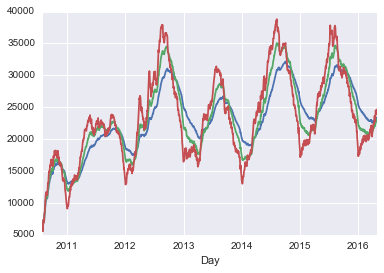

In [8]:
# Exponentially weighted moving average; weight on past series is controlled by alpha, the bigger the alpha the greater the drop
# off so when you increase alpha it becomes less smooth
hires.Hires.ewm(alpha=0.01).mean().plot()
hires.Hires.ewm(alpha=0.02).mean().plot()
hires.Hires.ewm(alpha=0.05).mean().plot()

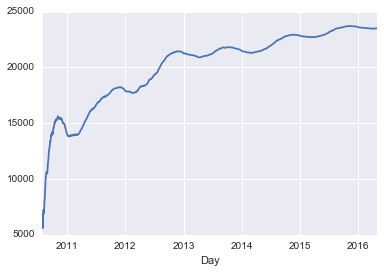

In [9]:
# Expanding average
hires.Hires.expanding().mean().plot()

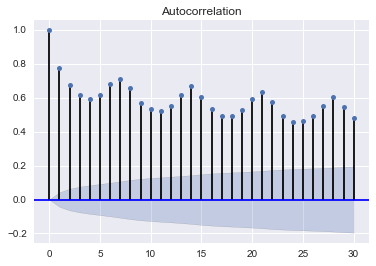

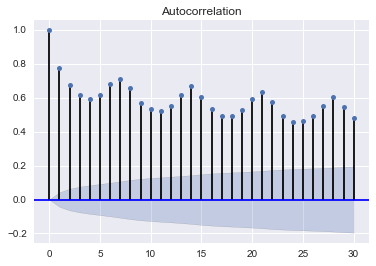

In [10]:
'''
Autocorrelation and stationarity
'''
# can see at lag 7 its more strongly correlated than others indicating a weekly trend
# can also see a trend
# significance increases overtime because the dataset shifts by 1 per lag and hence becomes smaller and smaller
# Autocorrelation function (ACF)
# should always specify a lag otherwise it would compute for everything
plot_acf(hires.Hires, lags=30)

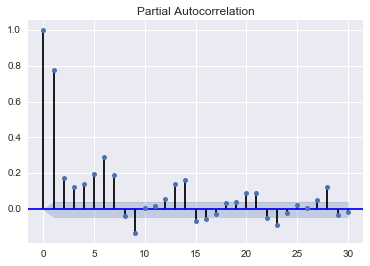

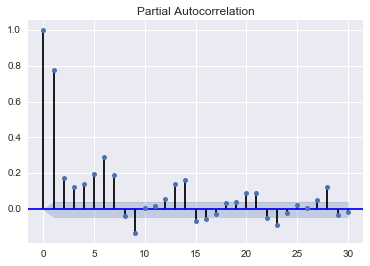

In [11]:
# first 2 bars same as other plot
# 3rd bar is adjuested on the second, basically second has captured 
# Partial autocorrelation function (PACF)
plot_pacf(hires.Hires, lags=30)

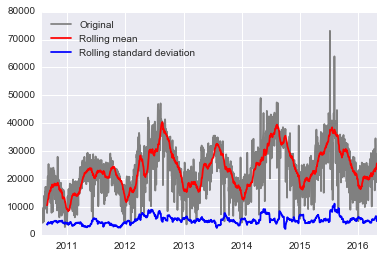

In [12]:
# Rolling statistics
def plot_rolling_statistics(ts):
    rolling_stats = ts.rolling(window=30).agg(['mean', 'std'])
    plt.plot(ts, color='gray', label='Original')
    plt.plot(rolling_stats['mean'], color='red', label='Rolling mean')
    plt.plot(rolling_stats['std'], color='blue', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.show(block=False)

plot_rolling_statistics(hires.Hires)
#not actually just number that goes up in summer but also the standard deviation, so

In [13]:
# Augmented Dickey-Fuller test (small p-values suggest stationarity)
sm.tsa.adfuller(hires.Hires)
# second value = p-value, if very small then we know series is stationary

(-3.2663778120517999,
 0.016449932213745282,
 26L,
 2075L,
 {'1%': -3.4335053773914268,
  '10%': -2.5675120499927422,
  '5%': -2.8629339035091039},
 40971.287683756454)

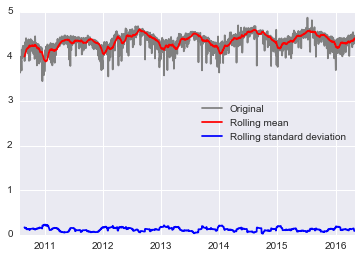

(-3.7589389960649289,
 0.0033564966114266871,
 26L,
 2075L,
 {'1%': -3.4335053773914268,
  '10%': -2.5675120499927422,
  '5%': -2.8629339035091039},
 -3349.3238568284778)

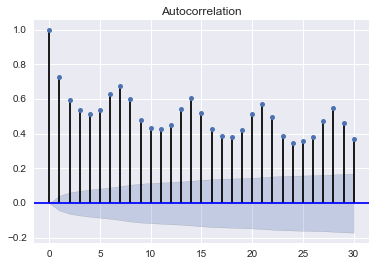

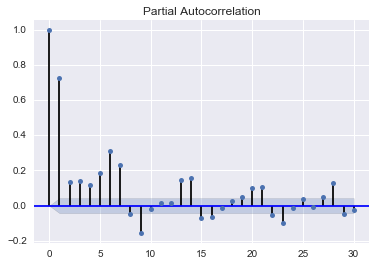

In [14]:
# Logarithmic transformation to stabilise variance
# if variation in the standard deviation a good way to get rd of it is to take the log
# after taking log we can see that the p-value is lower
hires_diff = np.log10(hires.Hires)

plot_rolling_statistics(hires_diff)
plot_acf(hires_diff, lags=30)
plot_pacf(hires_diff, lags=30)
sm.tsa.adfuller(hires_diff)

In [17]:
hires_diff

Day
2010-07-31   -0.093273
2010-08-01   -0.111616
2010-08-02    0.188528
2010-08-03    0.078941
2010-08-04   -0.003998
2010-08-05    0.043474
2010-08-06    0.050377
2010-08-07   -0.169514
2010-08-08    0.074064
2010-08-09   -0.103883
2010-08-10   -0.110339
2010-08-11    0.465109
2010-08-12   -0.029923
2010-08-13   -0.031996
2010-08-14   -0.121060
2010-08-15    0.074989
2010-08-16    0.148529
2010-08-17    0.000339
2010-08-18    0.018392
2010-08-19    0.028971
2010-08-20   -0.018288
2010-08-21   -0.147592
2010-08-22   -0.063324
2010-08-23    0.106200
2010-08-24    0.118836
2010-08-25   -0.227918
2010-08-26   -0.008147
2010-08-27    0.114501
2010-08-28   -0.104029
2010-08-29   -0.112302
                ...   
2016-04-01   -0.018310
2016-04-02   -0.048647
2016-04-03   -0.064051
2016-04-04    0.077467
2016-04-05    0.078269
2016-04-06   -0.096766
2016-04-07   -0.033549
2016-04-08    0.088024
2016-04-09   -0.139133
2016-04-10    0.071076
2016-04-11    0.014121
2016-04-12    0.105432
2016-04

In [15]:
# correlation with time series but adjusting for lag2

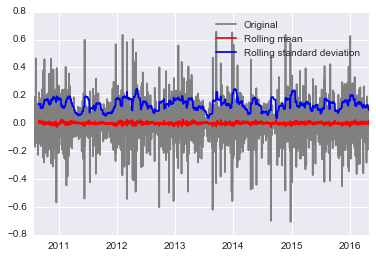

(-13.351060489162576,
 5.6674015339445571e-25,
 26L,
 2074L,
 {'1%': -3.4335069006776791,
  '10%': -2.5675124080943377,
  '5%': -2.8629345760724205},
 -3377.989340612472)

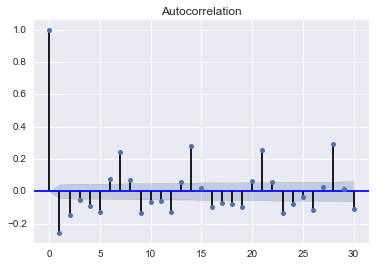

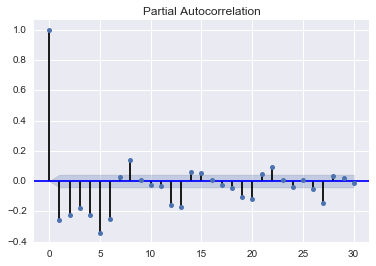

In [16]:
# First-order differencing to induce stationarity
# shift will shift function by one so basically t shift will be t-1
# have to drop na because last point of shift 
# can take differences of order 7 to get rid of lag7 in ACF
hires_diff = hires_diff - hires_diff.shift(1)
hires_diff.dropna(inplace=True)

plot_rolling_statistics(hires_diff)
plot_acf(hires_diff, lags=30)
plot_pacf(hires_diff, lags=30)
sm.tsa.adfuller(hires_diff)

In [22]:
'''
AR(I)MA modelling
'''

# Separate dataset into training and test sets
training = hires_diff[hires_diff.index < pd.to_datetime('2016-04-01')]
test = hires_diff[hires_diff.index >= pd.to_datetime('2016-04-01')]

# Fit ARMA(4, 2) model on the log-differences
# looking at ACF plot we can seee that after 4 it starts to drop off and hence this indicates that we should use 4 AR terms
model = sm.tsa.ARMA(training, (4, 2)).fit(maxiter=100)

model.summary()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARMA
====================================================================
Model:              ARMA             BIC:                 -3120.2196
Dependent Variable: Hires            Log-Likelihood:      1590.7    
Date:               2016-06-21 19:21 Scale:               1.0000    
No. Observations:   2071             Method:              css-mle   
Df Model:           7                Sample:              07-31-2010
Df Residuals:       2064                                  03-31-2016
Converged:          1.0000           S.D. of innovations: 0.112     
AIC:                -3165.3059       HQIC:                -3148.780 
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           0.0003    0.0012     0.2104  0.8334  -0.0021   0.0026
ar.L1.Hires     0.6781    0.0220    30.7699  0.0000   0.6349   0.7213
ar.L2.Hires    -0.6490    0.0258   -25.1818  0.0000  -0.6995  -0.5985
ar.L3.Hires    -0.1170    0.0254    -4.6074  0.0000  -0.1667  -0.0672
ar.L4.Hires    -0.3562    0.0213   -16.6991  0.0000  -0.3980  -0.3144
ma.L1.Hires    -1.2173    0.0094  -130.0981  0.0000  -1.2356  -1.1989
ma.L2.Hires     0.9226    0.0118    78.1452  0.0000   0.8995   0.9457
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.6254            -0.7839           1.0028            -0.1428
AR.2            0.6254             0.7839           1.0028             0.1428
AR.3           -0.7896            -1.4726           1.6709            -0.3283
AR.4           -0.7896             1.4726           1.6709             0.3283
MA.1            0.6597            -0.8054           1.0411            -0.1408
MA.2            0.6597             0.8054           1.0411             0.1408
====================================================================

"""

In [ ]:
# Check ACF and PACF of residuals
plot_acf(model.resid, lags=30)
plot_pacf(model.resid, lags=30)

C:\Users\shilau\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


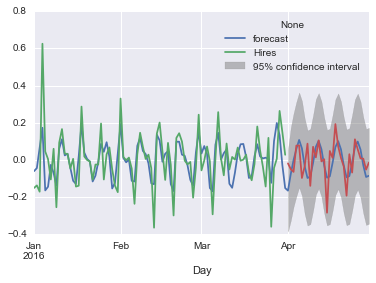

In [23]:
# Plot predictions and test set
model.plot_predict('2016-01-01', '2016-04-30')
test.plot()
#blue is prediction, and red is what happened.

In [25]:
# Alternatively, fit ARIMA(4, 1, 2) on the log-transformed counts
training = np.log10(hires.Hires[hires.index < pd.to_datetime('2016-04-01')])
test = np.log10(hires.Hires[hires.index >= pd.to_datetime('2016-04-01')])

model = sm.tsa.ARIMA(training, (4, 1, 2)).fit(maxiter=100)

model.summary()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            Log-Likelihood:      1590.7    
Dependent Variable: D.Hires          Scale:               1.0000    
Date:               2016-10-23 17:17 Method:              css-mle   
No. Observations:   2071             Sample:              07-31-2010
Df Model:           7                                     03-31-2016
Df Residuals:       2064             S.D. of innovations: 0.112     
AIC:                -3165.3059       HQIC:                -3148.780 
BIC:                -3120.2196                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           0.0003    0.0012     0.2104  0.8334  -0.0021   0.0026
ar.L1.D.Hires   0.6781    0.0220    30.7699  0.0000   0.6349   0.7213
ar.L2.D.Hires  -0.6490    0.0258   -25.1818  0.0000  -0.6995  -0.5985
ar.L3.D.Hires  -0.1170    0.0254    -4.6074  0.0000  -0.1667  -0.0672
ar.L4.D.Hires  -0.3562    0.0213   -16.6991  0.0000  -0.3980  -0.3144
ma.L1.D.Hires  -1.2173    0.0094  -130.0966  0.0000  -1.2356  -1.1989
ma.L2.D.Hires   0.9226    0.0118    78.1434  0.0000   0.8995   0.9457
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.6254            -0.7839           1.0028            -0.1428
AR.2            0.6254             0.7839           1.0028             0.1428
AR.3           -0.7896            -1.4726           1.6709            -0.3283
AR.4           -0.7896             1.4726           1.6709             0.3283
MA.1            0.6597            -0.8054           1.0411            -0.1408
MA.2            0.6597             0.8054           1.0411             0.1408
====================================================================

"""

C:\Users\shilau\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


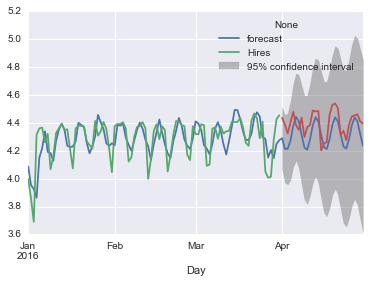

In [26]:
model.plot_predict('2016-01-01', '2016-04-30')
test.plot()

In [ ]:
#confidence interval becomes wider and wider because the further we try to predict the less data we have to predict off from
# and hence less confident